In [1]:
!pip install split-folders

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import glob
import PIL
import pathlib
import splitfolders
import random
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import CategoricalFocalCrossentropy
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import l2

In [3]:
splitfolders.ratio("/kaggle/input/eczema-disease/Eczema",
                   output="/kaggle/working/dataset_split",
                   ratio=(0.7, 0.15, 0.15))

Copying files: 1395 files [00:14, 94.22 files/s] 


In [4]:
data_dir_train = pathlib.Path( '/kaggle/working/dataset_split/train')
img_height,  img_width  = 299, 299

In [5]:
train_ds = image_dataset_from_directory(data_dir_train,
                                        seed = 123,
                                        image_size=(img_height, img_width))

Found 969 files belonging to 17 classes.


In [6]:
class_names = train_ds.class_names
class_names

['Atopic dermatitis childhood phase ',
 'Atopic dermatitis feet ',
 'Dyshidrosis',
 'Eczema areola',
 'Eczema asteatotic',
 'Eczema chronic',
 'Eczema fingertips',
 'Eczema foot',
 'Eczema hand',
 'Ichthyosis',
 'Keratolysis exfoliativa',
 'Keratosis pilaris',
 'Lichen simplex chronicus',
 'Neurotic excoriations',
 'Pompholyx',
 'Prurigo nodularis',
 'Stasis dermatitis']

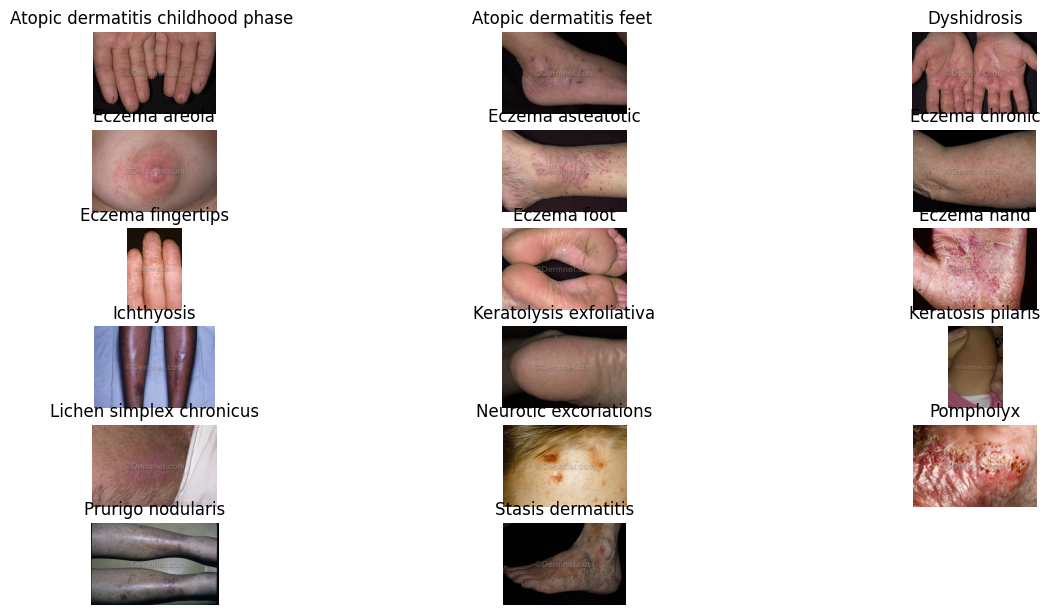

In [7]:
### Visualizing the training data
plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(8, 3, i+1)

    # Correct indentation for the following lines
    data_path = os.path.join(str(data_dir_train), class_)
    file_paths = glob.glob(os.path.join(data_path, '*.*'))
    random_img_path = random.choice(file_paths)
    img = PIL.Image.open(random_img_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")

plt.show()

In [8]:
class_size = {}
for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.*')))

class_size

{'Atopic dermatitis childhood phase ': 10,
 'Atopic dermatitis feet ': 11,
 'Dyshidrosis': 41,
 'Eczema areola': 15,
 'Eczema asteatotic': 35,
 'Eczema chronic': 36,
 'Eczema fingertips': 99,
 'Eczema foot': 67,
 'Eczema hand': 85,
 'Ichthyosis': 32,
 'Keratolysis exfoliativa': 35,
 'Keratosis pilaris': 222,
 'Lichen simplex chronicus': 91,
 'Neurotic excoriations': 42,
 'Pompholyx': 25,
 'Prurigo nodularis': 35,
 'Stasis dermatitis': 88}

In [9]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
Atopic dermatitis childhood phase,10
Atopic dermatitis feet,11
Dyshidrosis,41
Eczema areola,15
Eczema asteatotic,35
Eczema chronic,36
Eczema fingertips,99
Eczema foot,67
Eczema hand,85
Ichthyosis,32


# **Augmentation**

In [10]:
!pip install Augmentor

In [11]:
import Augmentor

In [12]:
path_to_training_dataset = '/kaggle/working/dataset_split/train/'
target_samples = 200  # Desired number of samples per class

for i in class_names:
    class_path = os.path.join(path_to_training_dataset, i)
    existing_samples = len(os.listdir(class_path))  # Count existing images
    additional_samples = max(0, target_samples - existing_samples)  # Calculate needed samples

    if additional_samples > 0:
        p = Augmentor.Pipeline(class_path, output_directory='')

        # 1.Rotation
        p.rotate(probability=0.9, max_left_rotation=25, max_right_rotation=25)

        # 2. Horizontal & Vertical Flip
        p.flip_left_right(probability=0.8)
        p.flip_top_bottom(probability=0.5)

        # 3. Random Zoom
        p.zoom_random(probability=0.4, percentage_area=0.5)

        # 4. Random Brightness
        p.random_brightness(probability=0.5, min_factor=0.4, max_factor=1.8)

        # 5. Random Contrast
        p.random_contrast(probability=0.4, min_factor=0.3, max_factor=2.0)


        # 7. Shearing
        p.shear(probability=0.4, max_shear_left=20, max_shear_right=20)

        # 8. Skewing
        p.skew(probability=0.4, magnitude=0.5)

        # 9. Gaussian Noise
        p.gaussian_distortion(probability=0.3, grid_width=5, grid_height=5, magnitude=8, corner='bell', method='in')

      

        # 12. Crop & Resize (For additional variation)
        p.crop_random(probability=0.3, percentage_area=0.7)
        p.resize(probability=1.0, width=299, height=299)

      

        # Generate only the necessary number of images
        p.sample(additional_samples)

Initialised with 10 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Atopic dermatitis childhood phase /.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D40F82E0B80>: 100%|██████████| 190/190 [00:10<00:00, 18.76 Samples/s]


Initialised with 11 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Atopic dermatitis feet /.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D40F82FD9F0>: 100%|██████████| 189/189 [00:10<00:00, 18.42 Samples/s]


Initialised with 41 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Dyshidrosis/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D40FC8325C0>: 100%|██████████| 159/159 [00:09<00:00, 16.51 Samples/s]


Initialised with 15 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Eczema areola/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D40FC830880>: 100%|██████████| 185/185 [00:11<00:00, 16.42 Samples/s]


Initialised with 35 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Eczema asteatotic/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D4169F4E8C0>: 100%|██████████| 165/165 [00:09<00:00, 17.89 Samples/s]


Initialised with 36 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Eczema chronic/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D4169F4EAD0>: 100%|██████████| 164/164 [00:08<00:00, 19.07 Samples/s]


Initialised with 99 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Eczema fingertips/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D4169F4D7E0>: 100%|██████████| 101/101 [00:06<00:00, 16.46 Samples/s]


Initialised with 67 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Eczema foot/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D4169F4E920>: 100%|██████████| 133/133 [00:07<00:00, 17.92 Samples/s]


Initialised with 85 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Eczema hand/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D4169F4D8A0>: 100%|██████████| 115/115 [00:06<00:00, 18.28 Samples/s]


Initialised with 32 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Ichthyosis/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D4169F4F100>: 100%|██████████| 168/168 [00:09<00:00, 18.20 Samples/s]


Initialised with 35 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Keratolysis exfoliativa/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D4169F4DA20>: 100%|██████████| 165/165 [00:09<00:00, 17.85 Samples/s]


Initialised with 91 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Lichen simplex chronicus/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D40F81F5180>: 100%|██████████| 109/109 [00:05<00:00, 20.42 Samples/s]


Initialised with 42 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Neurotic excoriations/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D40FC831E70>: 100%|██████████| 158/158 [00:08<00:00, 18.30 Samples/s]


Initialised with 25 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Pompholyx/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D40F81F7610>: 100%|██████████| 175/175 [00:10<00:00, 17.22 Samples/s]


Initialised with 35 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Prurigo nodularis/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D40F8373610>: 100%|██████████| 165/165 [00:09<00:00, 17.26 Samples/s]


Initialised with 88 image(s) found.
Output directory set to /kaggle/working/dataset_split/train/Stasis dermatitis/.

Processing <PIL.Image.Image image mode=RGB size=299x299 at 0x7D40FC830850>: 100%|██████████| 112/112 [00:05<00:00, 19.74 Samples/s]


In [13]:
batch_size = 32
epochs = 5
img_size = 299

In [14]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,
                               # horizontal flip
                                   brightness_range=[0.2,0.8])

test_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8])
training_set = train_datagen.flow_from_directory('/kaggle/working/dataset_split/train',
                                               target_size=(299,299),
                                                 batch_size=32)

test_set = test_datagen.flow_from_directory('/kaggle/working/dataset_split/val',
                                            target_size=(299,299),
                                            batch_size=32,
                                            shuffle=False)

Found 3422 images belonging to 17 classes.
Found 200 images belonging to 17 classes.


In [15]:
def Xception_finetune(weights_path):
    
    base_model = Xception(weights=None, include_top=False, input_shape=(299, 299, 3))
    
    base_model.load_weights(weights_path)

    base_model.trainable = False

    x = base_model.output
    

    # Add new classifier head
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    new_output = layers.Dense(17, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=new_output)
    # Use Categorical cross entropy 

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model, base_model

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=3,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [17]:
filepath = '/kaggle/working/checkpoint/Eczema_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath , save_best_only= True, monitor = 'val_accuracy')

In [18]:
os.makedirs('/kaggle/working/Models/categories/', exist_ok=True)

In [19]:
def train():
    time_start = time.time()

    # Initialize the model
    model, base_model = Xception_finetune(
        weights_path='/kaggle/input/weights/tensorflow2/default/1/category.weights.h5'
    )
    model.summary()

    # Phase 1: Train only the new top layers (all base layers frozen)
    print("\nPhase 1: Training top layers only...")

    history_all = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    history = model.fit(
        training_set,
        epochs=5,
        validation_data=test_set,
        callbacks=[early_stopping, learning_rate_reduction, reduce_lr, checkpoint]
    )

    for key in history.history:
        if key not in history_all:
            history_all[key] = []
        history_all[key] += history.history[key]

    # Prepare for progressive unfreezing
    total_layers = len(model.layers)
    unfrozen = 5
    max_unfreeze = 60
    phase = 2

    while unfrozen < total_layers and unfrozen <= max_unfreeze:
        print(f"\nPhase {phase}: Unfreezing last {unfrozen} layers...")

        for layer in model.layers[-unfrozen:]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True

        history = model.fit(
            training_set,
            epochs=5,
            validation_data=test_set,
            callbacks=[early_stopping, learning_rate_reduction, checkpoint]
        )

        for key in history.history:
            if key not in history_all:
                history_all[key] = []
            history_all[key] += history.history[key]

        unfrozen += 5
        phase += 1

    model.save_weights('/kaggle/working/Models/categories/Skin_cancer.weights.h5')
    model.save('/kaggle/working/Models/categories/Skin_cancer.h5')

    print('Model saved.')
    print('Training Time:', time.time() - time_start)
    print('\n')

    return history_all


In [24]:
from tensorflow.keras.models import load_model

def test():
    #test_labels = np.array(test_labels)

    from tensorflow import keras
    print('Testing:')
    mod = load_model('/kaggle/working/Models/categories/Skin_cancer.h5')
    mod.evaluate(test_set)

    prob = mod.predict(test_set)
    predIdxs = np.argmax(prob, axis=1)


    print('\n')
    print(classification_report(test_set.labels, predIdxs,target_names = key, digits=5))
    return  prob, predIdxs, mod

In [21]:
input_path = '/kaggle/working/dataset_split/val'
train_data = image_dataset_from_directory(directory=input_path,
                                              batch_size=32,
                                              image_size=(299, 299))

Found 200 files belonging to 17 classes.


In [22]:

def plot_training_history(history_all):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_all['loss'], label='Training Loss')
    plt.plot(history_all['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_all['accuracy'], label='Training Accuracy')
    plt.plot(history_all['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

if __name__ == "__main__":
    key = train_data.class_names
    train_history = train()
    prob, predIdxs, model = test()

    # Plot training history
    plot_training_history(train_history)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 21,134,137 (80.62 MB)

 Trainable params: 268,561 (1.02 MB)

 Non-trainable params: 20,865,576 (79.60 MB)


Phase 1: Training top layers only...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.0896 - loss: 5.9521 - val_accuracy: 0.3100 - val_loss: 5.1161 - learning_rate: 3.0000e-04
Epoch 2/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 88s 773ms/step - accuracy: 0.1725 - loss: 5.0645 - val_accuracy: 0.4000 - val_loss: 4.6556 - learning_rate: 3.0000e-04
Epoch 3/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 89s 786ms/step - accuracy: 0.2171 - loss: 4.6611 - val_accuracy: 0.4250 - val_loss: 4.2023 - learning_rate: 3.0000e-04
Epoch 4/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 89s 778ms/step - accuracy: 0.2712 - loss: 4.2757 - val_accuracy: 0.4300 - val_loss: 3.7746 - learning_rate: 3.0000e-04
Epoch 5/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 89s 784ms/step - accuracy: 0.3147 - loss: 3.9614 - val_accuracy: 0.4050 - val_loss: 3.5209 - learning_rate: 3.0000e-04

Phase 2: Unfreezing last 5 layers...
Epoch 1/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 89s 786ms/step - accuracy: 0.3370 - loss: 3.7157 - val_accuracy: 0.4250 - val_loss: 3.3130 - learning_rate: 3.0000e-04
Epoch 2/5
107/107 ━━━━━━━━

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/working/Models/categories/Eczema.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [26]:
# Define test data generator for final testing
final_test_datagen = ImageDataGenerator(rescale=1./255)

# Load final test set
final_test_set = final_test_datagen.flow_from_directory('/kaggle/working/dataset_split/test/',
                                                        target_size=(299, 299),
                                                        batch_size=32,
                                                        shuffle=False)  

# Load the model
mod = keras.models.load_model('/kaggle/working/Models/categories/Skin_cancer.h5')
 
# Evaluate the model on the final test set
final_test_loss, final_test_accuracy = mod.evaluate(final_test_set)
print(f'Final Test Loss: {final_test_loss}')
print(f'Final Test Accuracy: {final_test_accuracy}')

# Predicting and classification report
prob = model.predict(final_test_set)
predIdxs = np.argmax(prob, axis=1)

# Get class names from class indices
class_names = list(final_test_set.class_indices.keys())

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(final_test_set.classes, predIdxs, target_names=class_names))

Found 226 images belonging to 17 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 941ms/step - accuracy: 0.5269 - loss: 2.0244
Final Test Loss: 1.859521746635437
Final Test Accuracy: 0.5929203629493713
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step
                                    precision    recall  f1-score   support

Atopic dermatitis childhood phase        0.00      0.00      0.00         3
           Atopic dermatitis feet        0.33      0.25      0.29         4
                       Dyshidrosis       1.00      0.10      0.18        10
                     Eczema areola       1.00      0.50      0.67         4
                 Eczema asteatotic       1.00      0.56      0.71         9
                    Eczema chronic       0.50      0.11      0.18         9
                 Eczema fingertips       0.53      0.95      0.68        22
                       Eczema foot       0.75      0.56      0.64        16
                       Eczema hand       0.59      0.53      0.56        19
                        Ichthyosis       0.80      

In [25]:
  prob, predIdxs, model = test()

Testing:
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 859ms/step - accuracy: 0.5028 - loss: 2.0500
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 988ms/step


                                    precision    recall  f1-score   support

Atopic dermatitis childhood phase     0.00000   0.00000   0.00000         2
           Atopic dermatitis feet     0.00000   0.00000   0.00000         2
                       Dyshidrosis    0.00000   0.00000   0.00000         8
                     Eczema areola    1.00000   1.00000   1.00000         3
                 Eczema asteatotic    0.80000   0.57143   0.66667         7
                    Eczema chronic    0.20000   0.14286   0.16667         7
                 Eczema fingertips    0.59375   0.90476   0.71698        21
                       Eczema foot    0.41667   0.35714   0.38462        14
                       Eczema hand    0.52941   0.50000   0.51429        18
                        Ichthyosis    1.00000   0.16667   0.28571         6
           Keratolysis exfoliativa    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


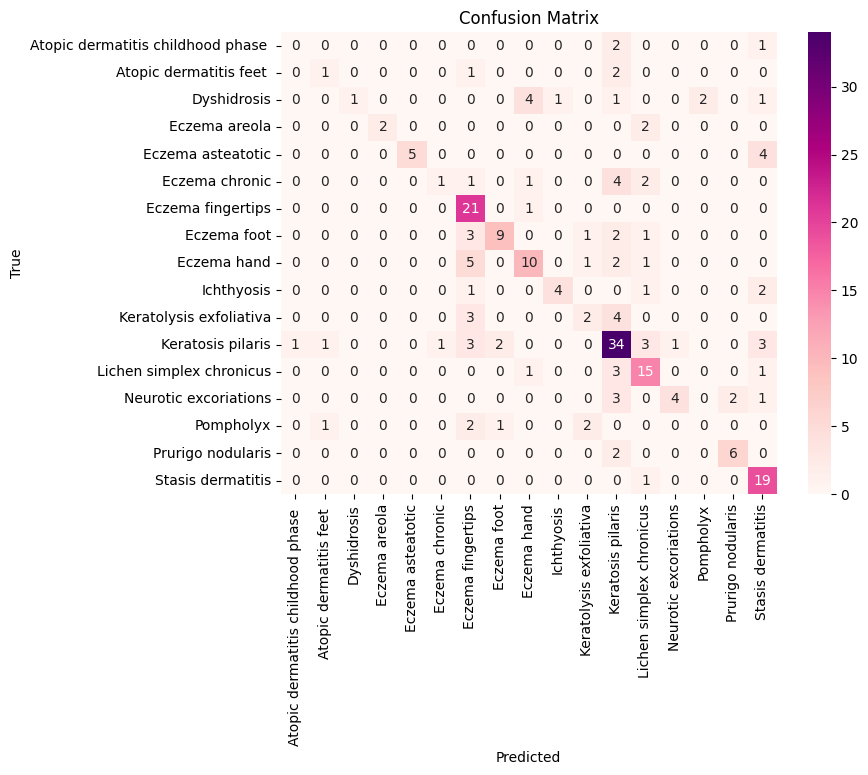

In [28]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(final_test_set.classes, predIdxs)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdPu', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

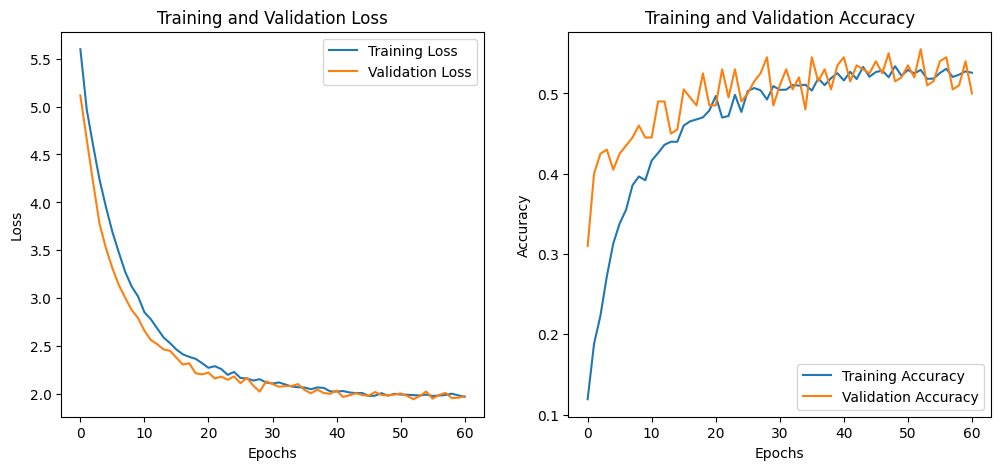

In [29]:
 plot_training_history(train_history)